# Tutorial on the LIDA Python API

Lida offers a manager class that exposes core functionality of the LIDA system. This tutorial will show you how to use the manager class to create visualizations based on a dataset. 


- LIDA supports multiple LLM backends such as `openai`, `cohere`, `palm`, `huggingface` etc. You can switch between backends by setting the `llm` parameter in the `Manager` class. By default, LIDA uses the `openai` backend. For a list of supported models etc, see the [llmx documentation](https://github.com/victordibia/llmx)
- The summarizer module works takes an `enrich` argument which determines if the base summary is enriched by an LLM. By default, the `enrich` argument is set to `False`. 

In [15]:
import json 
from lida import TextGenerationConfig , llm
from lida.modules import Manager
from lida.utils import plot_raster 

## Summarize Data, Generate Goals

In [16]:
lida = Manager(text_gen = llm("openai")) # or llm("palm") etc
textgen_config = TextGenerationConfig(n=1, temperature=0.5, use_cache=True, max_tokens=1000)

summary = lida.summarize("https://raw.githubusercontent.com/uwdata/draco/master/data/cars.csv", enrich=False, textgen_config=textgen_config) 
goals = lida.generate_goals(summary, n=2, textgen_config=textgen_config)
print(goals)

[Goal(index=0, question='What is the relationship between Retail_Price and Horsepower_HP_?', visualization='scatter plot of Retail_Price and Horsepower_HP_', rationale='This will help understand if there is any correlation between the price of a car and its horsepower, which could be useful for pricing strategies or marketing campaigns.'), Goal(index=1, question='What is the distribution of City_Miles_Per_Gallon across different car types?', visualization='box plot of City_Miles_Per_Gallon by Type', rationale='This will help understand if there are any significant differences in fuel efficiency between car types, which could be useful for car manufacturers or consumers looking to make informed decisions about purchasing a car.')]


/home/victordibia/projects/projectlida/lida/lida/modules/summarizer.py:51: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df[column], errors='raise')
/home/victordibia/projects/projectlida/lida/lida/modules/summarizer.py:51: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df[column], errors='raise')


## Generate Visualizations

Code for generated chart: import matplotlib.pyplot as plt
import pandas as pd

def plot(data: pd.DataFrame):
    # scatter plot of Retail_Price and Horsepower_HP_
    plt.scatter(data['Retail_Price'], data['Horsepower_HP_'], alpha=0.5, color='blue')
    plt.xlabel('Retail Price')
    plt.ylabel('Horsepower')
    plt.title('What is the relationship between Retail_Price and Horsepower_HP_?')
    return plt;

chart = plot(data)


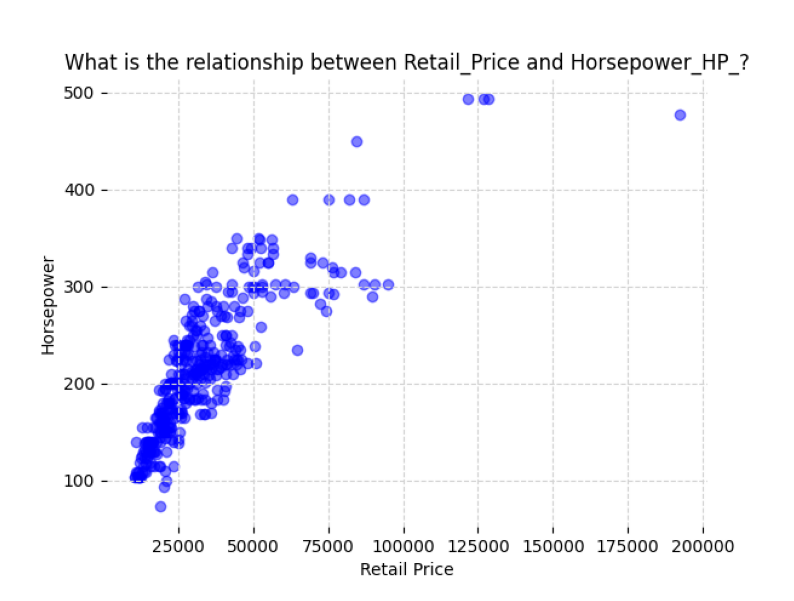

In [17]:
i = 0
library = "matplotlib"
textgen_config = TextGenerationConfig(n=1, temperature=0, use_cache=True, max_tokens=2000)
vis_specs = lida.generate_viz(summary=summary, goal=goals[i], textgen_config=textgen_config, library=library) 
charts = lida.execute_viz(code_specs=vis_specs, data=lida.data, summary=summary, library=library )
print("Code for generated chart:", charts[0].code)

# plot raster image of chart
plot_raster(charts[0].raster) 

In [18]:
vis_specs

["import matplotlib.pyplot as plt\nimport pandas as pd\n\ndef plot(data: pd.DataFrame):\n    # scatter plot of Retail_Price and Horsepower_HP_\n    plt.scatter(data['Retail_Price'], data['Horsepower_HP_'], alpha=0.5, color='blue')\n    plt.xlabel('Retail Price')\n    plt.ylabel('Horsepower')\n    plt.title('What is the relationship between Retail_Price and Horsepower_HP_?')\n    return plt;\n\nchart = plot(data) # data already contains the data to be plotted. Always include this line. DO NOT modify the rest of the code template."]

# VizOps

Given that LIDA represents visualizations as code,
the VISGENERATOR also implements submodules
to perform operations on this representation. 

This includes 
- **Natural language based visualization refinement**: Provides a conversational api to iteratively
4Execution in a sandbox environment is recommended.
refine generated code (e.g., translate chart t hindi
. . . zoom in by 50% etc) which can then be executed to generate new visualizations.
- **Visualization explanations and accessibility**:
Generates natural language explanations (valuable
for debugging and sensemaking) as well as accessibility descriptions (valuable for supporting users
with visual impairments).

- **Visualization code self-evaluation and repair**:
Applies an LLM to self-evaluate generated code on
multiple dimensions (see section 4.1.2).

- **Visualization recommendation**: Given some context (goals, or an existing visualization), recommend additional visualizations to the user (e.g., for
comparison, or to provide additional perspectives).



## Natural language based visualization refinement 

Given some code, modify it based on natural language instructions. This yields a new code snippet that can be executed to generate a new visualization.

In [19]:
code = charts[0].code
instructions = ["convert this to a bar chart", "change the color to red", "change y axes label to Fuel Efficiency"," ensure axis are legible"]
vis_specs = lida.edit_viz(code=code,  summary=summary, instructions=instructions, library=library)

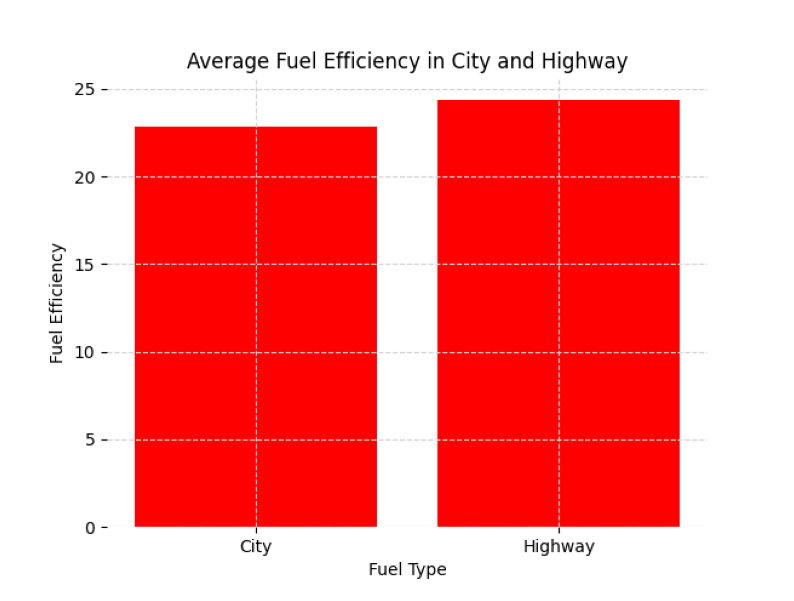

In [20]:
edited_charts = lida.execute_viz(code_specs=vis_specs, data=lida.data, summary=summary, library=library) 
plot_raster(edited_charts[0].raster)

## Visualization explanations and accessibility

In [21]:
explanations = lida.explain_viz(code=code,  library=library) 

In [22]:
print(explanations)

[[{'section': 'accessibility', 'code': 'None', 'explanation': 'The code generates a scatter plot using the matplotlib library to visualize the relationship between the Retail_Price and Horsepower_HP_ columns of a given pandas DataFrame.'}, {'section': 'transformation', 'code': 'None', 'explanation': 'There is no data transformation in this code.'}, {'section': 'visualization', 'code': "plt.scatter(data['Retail_Price'], data['Horsepower_HP_'], alpha=0.5, color='blue')\nplt.xlabel('Retail Price')\nplt.ylabel('Horsepower')\nplt.title('What is the relationship between Retail_Price and Horsepower_HP_?')\nreturn plt;", 'explanation': "The code first generates a scatter plot using the 'scatter' method of the matplotlib library. The 'Retail_Price' column is used as the x-axis and the 'Horsepower_HP_' column is used as the y-axis. The 'alpha' parameter is set to 0.5 to make the points semi-transparent and the 'color' parameter is set to 'blue' to make the points blue. The 'xlabel' and 'ylabel' 

In [23]:
for row in explanations[0]:
    print(row["section"]," ** ", row["explanation"])

accessibility  **  The code generates a scatter plot using the matplotlib library to visualize the relationship between the Retail_Price and Horsepower_HP_ columns of a given pandas DataFrame.
transformation  **  There is no data transformation in this code.
visualization  **  The code first generates a scatter plot using the 'scatter' method of the matplotlib library. The 'Retail_Price' column is used as the x-axis and the 'Horsepower_HP_' column is used as the y-axis. The 'alpha' parameter is set to 0.5 to make the points semi-transparent and the 'color' parameter is set to 'blue' to make the points blue. The 'xlabel' and 'ylabel' methods are used to label the x and y axes respectively. The 'title' method is used to set the title of the plot. Finally, the 'plt' object is returned.


## Visualization code self-evaluation and repair

In [24]:
evaluations = lida.evaluate_viz(code=code,  goal=goals[i], library=library)
evaluations = json.loads(evaluations[0])

In [14]:
for eval in evaluations:
    print(eval["dimension"], "Score" ,eval["score"], "/ 10")
    print("\t", eval["rationale"][:200])

bugs Score 10 / 10
	 The code is free of bugs, syntax errors, and typos. It should compile without any issues.
transformation Score 10 / 10
	 There is no data transformation needed for this visualization. The code is using the original data.
compliance Score 9 / 10
	 The code meets the specified visualization goal of showing the relationship between Retail_Price and Horsepower_HP_. However, it could be improved by adding a regression line to better visualize the t
type Score 9 / 10
	 The scatter plot is an appropriate visualization type for showing the relationship between two continuous variables. However, a regression plot or a heat map could be more effective in conveying the t
encoding Score 10 / 10
	 The data is encoded appropriately by using the Retail_Price and Horsepower_HP_ variables for the x and y axes, respectively.
aesthetics Score 9 / 10
	 The aesthetics of the visualization are appropriate for a scatter plot. However, the color and alpha values could be improved to bette